---
title: 'STATS 202 Homework 3'
project:
  output-dir: output
format: pdf
author: "Alistair Keiller"
execute: 
  enabled: true
---

In [36]:
import csv
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from autogluon.tabular import TabularPredictor
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

sns.set_theme()

In [172]:
path = "FinalProjectData"

data = pd.concat(
    [pd.read_csv(os.path.join(path, f)) for f in os.listdir(path) if f.endswith(".csv")]
)
data["PSUM"] = np.sum([data["P" + str(n)] for n in range(1, 8)], axis=0)
data["NSUM"] = np.sum([data["N" + str(n)] for n in range(1, 8)], axis=0)
data["GSUM"] = np.sum([data["G" + str(n)] for n in range(1, 17)], axis=0)
data["Treatment"] = data["TxGroup"] == "Treatment"
data["Flagged"] = data["LeadStatus"] != "Passed"
PANSS_parts = [
    "P1",
    "P2",
    "P3",
    "P4",
    "P5",
    "P6",
    "P7",
    "N1",
    "N2",
    "N3",
    "N4",
    "N5",
    "N6",
    "N7",
    "G1",
    "G2",
    "G3",
    "G4",
    "G5",
    "G6",
    "G7",
    "G8",
    "G9",
    "G10",
    "G11",
    "G12",
    "G13",
    "G14",
    "G15",
    "G16",
]
data

,Study,Country,PatientID,SiteID,RaterID,AssessmentID,TxGroup,VisitDay,P1,P2,...,G14,G15,G16,PANSS_Total,LeadStatus,PSUM,NSUM,GSUM,Treatment,Flagged
0,A,USA,10001,20035,30076,100679,Control,0,5,5,...,3,3,5,107,Assign to CS,30,24,53,False,True
1,A,USA,10001,20035,30076,101017,Control,11,5,5,...,3,3,5,109,Assign to CS,30,25,54,False,True
2,A,USA,10001,20035,30076,102177,Control,18,4,4,...,2,3,4,91,Passed,23,24,44,False,False
3,A,USA,10001,20035,30076,101533,Control,25,3,3,...,2,3,4,80,Flagged,19,22,39,False,True
4,A,USA,10001,20035,30076,100930,Control,39,3,3,...,2,3,4,77,Flagged,19,21,37,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2943,D,China,40223,80001,120013,400496,Treatment,17,4,3,...,2,4,4,79,Flagged,18,21,40,True,True
2944,D,China,40223,80001,120013,402261,Treatment,21,4,3,...,2,3,3,71,Flagged,18,18,35,True,True
2945,D,China,40223,80001,120013,400605,Treatment,28,4,3,...,2,3,3,74,Flagged,19,19,36,True,True
2946,D,China,40223,80001,120013,402460,Treatment,42,4,3,...,2,4,3,77,Flagged,19,20,38,True,True


# 1 Treatment effect

We will clearly define our tests before observing or analyzing the data to simulate the regulations that prevent data snooping in regulated industries. The goal is to determine if the treatment ( $\text{TxGroup} == \text{Treatment}$, which will be our preprocessing step ) has an effect on schizophrenia over time, as measured by the PANSS score ( $\text{PANSS\_Total}$ ). So, we want to see if there is a change in $\text{PANSS\_Total}$ over time, which can be determined by looking for a correlation between $\text{VisitDay}$ and $\text{PANSS\_Total}$ using a linear regression model:

$$\text{PANSS\_Total}=\hat{\beta_0}+\hat{\beta_1}\text{VisitDay}$$

Our null hypothesis is that the treatment has no effect, and we can reject the null hypothesis if and only if we find that $\hat{\beta_1}\neq 0$ with a $p<0.05$.

In [38]:
smf.ols(
    "PANSS_Total ~ VisitDay*Treatment", data=data[data.LeadStatus == "Passed"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PANSS_Total   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     3467.
Date:                Wed, 02 Aug 2023   Prob (F-statistic):               0.00
Time:                        16:41:02   Log-Likelihood:                -64467.
No. Observations:               15841   AIC:                         1.289e+05
Df Residuals:                   15837   BIC:                         1.290e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     82.9635      0.222    374.211      0.000      82.529      83.398
Treatment[T.True]             -1.0590      0.320     -3.310      0.001      -1.686      -0.432
VisitDay                      -0.1177      0.002    -73.833      0.000      -0.121      -0.115
VisitDay:Treatment[T.True]     0.0053      0.002      2.330      0.020       0.001       0.010
==============================================================================
Omnibus:                      418.754   Durbin-Watson:                   0.530
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              497.541
Skew:                           0.351   Prob(JB):                    9.13e-109
Kurtosis:                       3.512   Cond. No.                         522.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

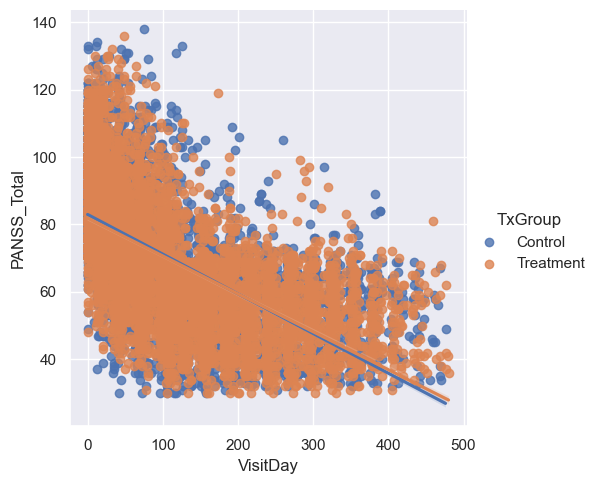

In [39]:
sns.lmplot(
    x="VisitDay",
    y="PANSS_Total",
    data=data[data.LeadStatus == "Passed"],
    hue="TxGroup",
)
plt.show()

In [40]:
smf.ols(
    "PSUM ~ VisitDay*Treatment", data=data[data.LeadStatus == "Passed"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   PSUM   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     2627.
Date:                Wed, 02 Aug 2023   Prob (F-statistic):               0.00
Time:                        16:41:03   Log-Likelihood:                -48160.
No. Observations:               15841   AIC:                         9.633e+04
Df Residuals:                   15837   BIC:                         9.636e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     19.9753      0.079    252.221      0.000      19.820      20.131
Treatment[T.True]             -0.3030      0.114     -2.652      0.008      -0.527      -0.079
VisitDay                      -0.0366      0.001    -64.317      0.000      -0.038      -0.036
VisitDay:Treatment[T.True]     0.0017      0.001      2.087      0.037       0.000       0.003
==============================================================================
Omnibus:                      786.417   Durbin-Watson:                   0.509
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              907.748
Skew:                           0.571   Prob(JB):                    7.67e-198
Kurtosis:                       3.269   Cond. No.                         522.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

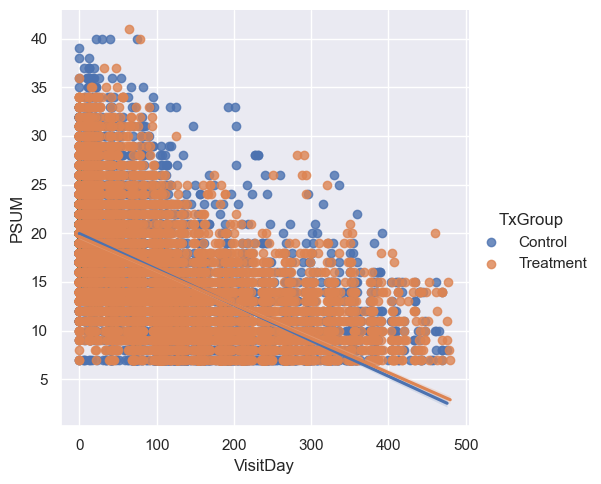

In [41]:
sns.lmplot(
    x="VisitDay",
    y="PSUM",
    data=data[data.LeadStatus == "Passed"],
    hue="TxGroup",
)
plt.show()

In [42]:
smf.ols(
    "NSUM ~ VisitDay*Treatment", data=data[data.LeadStatus == "Passed"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   NSUM   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     1291.
Date:                Wed, 02 Aug 2023   Prob (F-statistic):               0.00
Time:                        16:41:04   Log-Likelihood:                -47217.
No. Observations:               15841   AIC:                         9.444e+04
Df Residuals:                   15837   BIC:                         9.447e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     22.2323      0.075    297.944      0.000      22.086      22.379
Treatment[T.True]             -0.1657      0.108     -1.539      0.124      -0.377       0.045
VisitDay                      -0.0238      0.001    -44.299      0.000      -0.025      -0.023
VisitDay:Treatment[T.True]     0.0003      0.001      0.367      0.713      -0.001       0.002
==============================================================================
Omnibus:                      166.462   Durbin-Watson:                   0.511
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.395
Skew:                           0.219   Prob(JB):                     4.08e-40
Kurtosis:                       3.287   Cond. No.                         522.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

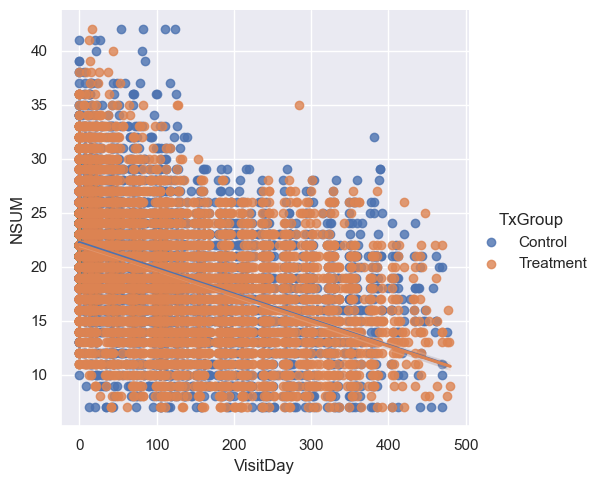

In [43]:
sns.lmplot(
    x="VisitDay",
    y="NSUM",
    data=data[data.LeadStatus == "Passed"],
    hue="TxGroup",
)
plt.show()

In [44]:
smf.ols(
    "GSUM ~ VisitDay*Treatment", data=data[data.LeadStatus == "Passed"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GSUM   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     2979.
Date:                Wed, 02 Aug 2023   Prob (F-statistic):               0.00
Time:                        16:41:05   Log-Likelihood:                -54166.
No. Observations:               15841   AIC:                         1.083e+05
Df Residuals:                   15837   BIC:                         1.084e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     40.7559      0.116    352.228      0.000      40.529      40.983
Treatment[T.True]             -0.5903      0.167     -3.535      0.000      -0.918      -0.263
VisitDay                      -0.0573      0.001    -68.877      0.000      -0.059      -0.056
VisitDay:Treatment[T.True]     0.0033      0.001      2.799      0.005       0.001       0.006
==============================================================================
Omnibus:                      500.923   Durbin-Watson:                   0.584
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              580.379
Skew:                           0.406   Prob(JB):                    9.38e-127
Kurtosis:                       3.470   Cond. No.                         522.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

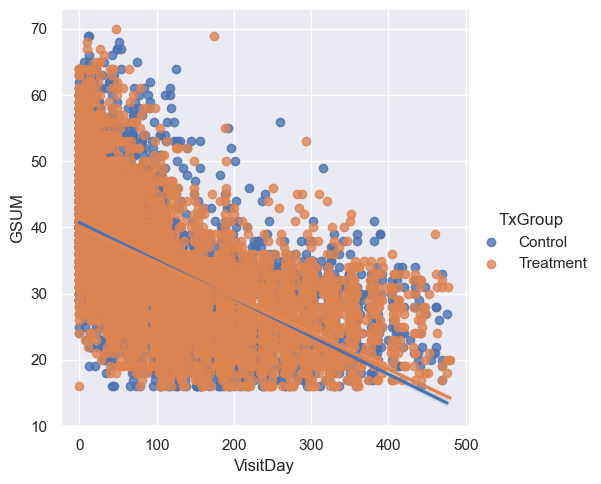

In [45]:
sns.lmplot(
    x="VisitDay",
    y="GSUM",
    data=data[data.LeadStatus == "Passed"],
    hue="TxGroup",
)
plt.show()

We can say with statistical significance that the control treatment is more effective than the new treatment, with a $\hat{\beta'}_1\approx -0.1208$ versus $\hat{\beta}_1\approx -0.1134$, however, that does not mean that the new treatment is ineffective. For example, if it has other advantages like few side effects or lower cost, preventing the control treatment from being an option, this study showing the efficacy of the new treatment could be critical information. Overall, it is not more effective / an improvement over the control, but based on existing research it is significantly better than untreated Schizophrenia, which often gets worse over time. However, **it is effective**.

**ADD MORE ANALISYS HERE** talk about how the inital treatment group tends to be less schizophrenic than the control group. Solving this could be the object of a future study that is randmly assigns control and treatment such that the intial values are identical, becuase trying to artifically normilize them in this study, given that the initial groups are statistically significantly different, will result in other ( possibly unseen ) artifacts.

# 2 Patient segmentation

First, we need to preprocess the data. We want to filter the data only to consider initial measurements of patients, and we want to scale each of the variables used in the evaluation to zero means and unit variance for equal emphasis on more and less sensitive measurements.

In [46]:
first_day_passed_data = data[
    (data.LeadStatus == "Passed") & (data.VisitDay == 0)
].copy()
scaled_numerical_first_day_passed_data = StandardScaler().fit_transform(
    first_day_passed_data[PANSS_parts]
)

Also, let's check if there are many double first day measurments to see if that could skew the data

In [47]:
len(first_day_passed_data["PatientID"])

1747

In [48]:
len(np.unique(first_day_passed_data["PatientID"]))

1745

Nope, that is not a problem so we can ignore that as a possible skew of the data.

Now we can run a highirichical clustering to create a dendrogram since our dataset is relatively small

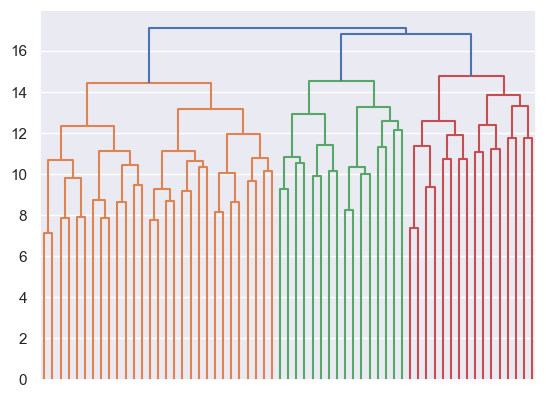

In [49]:
dendrogram(
    linkage(scaled_numerical_first_day_passed_data, method="complete"),
    truncate_mode="level",
    p=5,
    no_labels=True,
    color_threshold=16,
)
plt.show()

$3$ seems like the most sensible value. To confirm these values, let's run a KMeans $n$ vs. $\text{error}$ to confirm this cluster size.

/opt/homebrew/Caskroom/miniconda/base/envs/final/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/final/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/final/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/final/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in

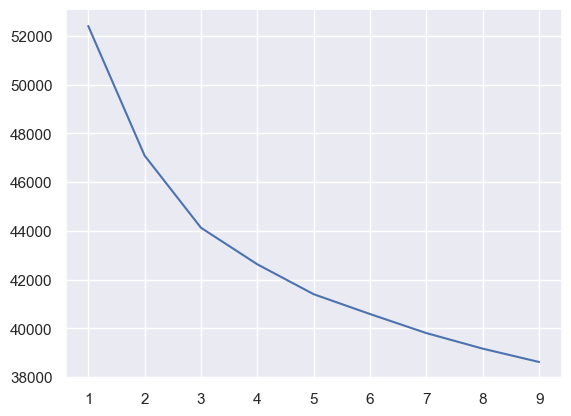

In [50]:
sns.lineplot(
    x=range(1, 10),
    y=[
        KMeans(n_clusters=n, random_state=42)
        .fit(scaled_numerical_first_day_passed_data)
        .inertia_
        for n in range(1, 10)
    ],
)
plt.show()

The new graph confirms that $3$ is a valid choice

In [51]:
first_day_passed_data["Cluster"] = (
    KMeans(n_clusters=3, random_state=42)
    .fit(scaled_numerical_first_day_passed_data)
    .labels_
)

/opt/homebrew/Caskroom/miniconda/base/envs/final/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [52]:
first_day_passed_data.groupby("Cluster")[
    ["PANSS_Total", "PSUM", "NSUM", "GSUM"]
].mean().reset_index()

,Cluster,PANSS_Total,PSUM,NSUM,GSUM
0,0,83.567944,23.243902,18.993031,41.331010
1,1,102.056311,25.300971,26.928155,49.827184
2,2,80.577508,17.320669,23.671733,39.585106


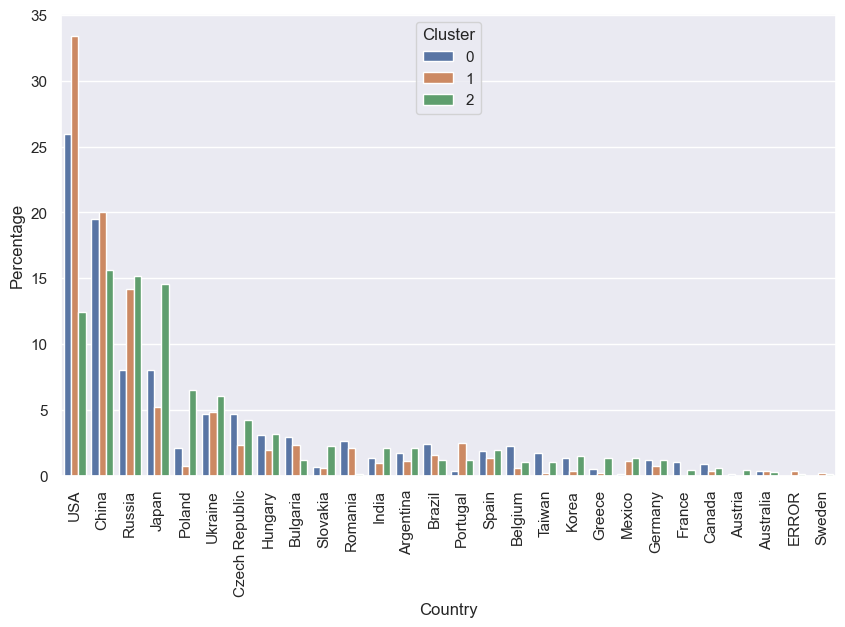

In [162]:
country_cluster_counts = first_day_passed_data[["Country", "Cluster"]].value_counts()
cluster_counts = first_day_passed_data["Cluster"].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Country",
    y="Percentage",
    hue="Cluster",
    data=(
        country_cluster_counts
        * 100
        / [cluster_counts[i] for i in country_cluster_counts.reset_index()["Cluster"]]
    ).reset_index(name="Percentage"),
)
plt.xticks(rotation=90)
plt.show()

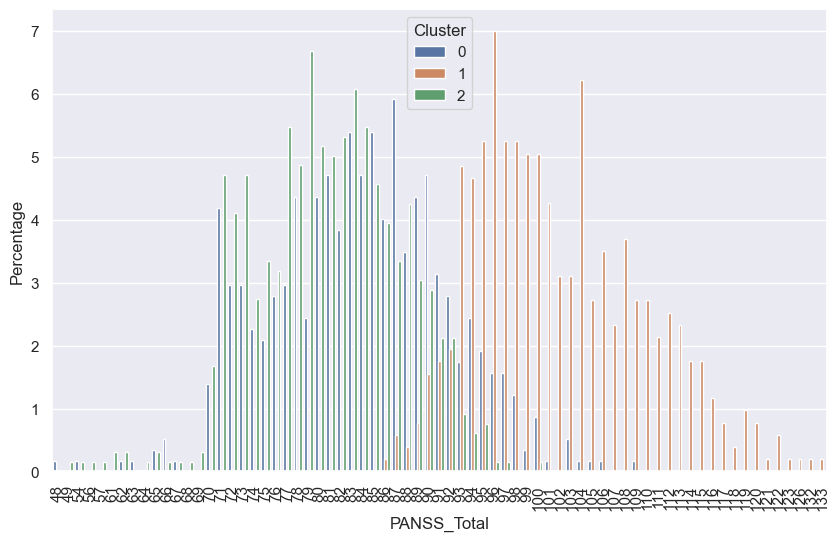

In [20]:
PANSS_Total_cluster_counts = first_day_passed_data[
    ["PANSS_Total", "Cluster"]
].value_counts()
cluster_counts = first_day_passed_data["Cluster"].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(
    x="PANSS_Total",
    y="Percentage",
    hue="Cluster",
    data=(
        PANSS_Total_cluster_counts
        / [
            cluster_counts[i] / 100
            for i in PANSS_Total_cluster_counts.reset_index()["Cluster"]
        ]
    ).reset_index(name="Percentage"),
)
plt.xticks(rotation=90)
plt.show()

The clusters that form are
- **Cluster 1:** Exhibit slightly more positive and significantly more negative and general schizophrenic metrics than average
- **Cluster 2:** Exhibit significantly less positive, negative, and general schizophrenic metrics than average
- **Cluster 3:** Exhibit significantly more positive, and slightly more negative and general schizophrenic metrics than average
- **Cluster 4:** Exhibit less positive, a tiny bit less general, and more negative schizophrenic metrics than average
- **Cluster 5:** Exhibit slightly more positive, less negative, and the tiniest bit less general metrics than average.
In these groups, groups $1$ and $3$ would be the most important to look into because they will be the most likely to have schizophrenia-related problems, and this shows approximately what type of problems may arise in those groups ( the generally more negative problem groups with still a significant amount of positive and general, and more positive groups with a significant amount of general and less negative ). This also provides the basis for further investigation into the specifics of each metric. However, as a simple clustering algorithm, these results should be taken lightly not to mean that groups $2$ and $4$ are the only important ones.

# 3 Forecasting



In [253]:
# Get the last recorded PANSS_Total for each PatientID as our guess for week 18
data[data.Study == "E"].groupby(["PatientID"]).last().reset_index()[
    ["PatientID", "PANSS_Total"]
].to_csv("week18.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

In [383]:
def add_previous_as_context(x, number_of_observations):
    return pd.DataFrame({
        **{
            f"{key}_{n}": x[key].shift(n)
            for n in range(1,number_of_observations+1)
            for key in ["VisitDay", *PANSS_parts]
        },
        **{
            key: x[key]
            for key in ["PANSS_Total", "Treatment", "Study", "Country"]
        }
    })

tp = [
    TabularPredictor(
        label="PANSS_Total",
        eval_metric="root_mean_squared_error",
        problem_type="regression",
    ).fit(
        data.groupby("PatientID").apply(add_previous_as_context, number_of_observations=number_of_observations).dropna(),
        presets="best_quality",
        hyperparameters={
            "KNN": {},
            "LR": {},
            "RF": {},
            "XGB": {},
            "CAT": {},
            "XT": {},
            "GBM": [
                {},
                {"extra_trees": True, "ag_args": {"name_suffix": "XT"}},
                "GBMLarge",
            ],
            "NN_TORCH": {},
            "FASTAI": {},
        },
    )
    for number_of_observations in range(1, 19)
]

No path specified. Models will be saved in: "AutogluonModels/ag-20230803_075753/"
/var/folders/8f/dmypnd_j6h5gwtjwt90wyw680000gn/T/ipykernel_27358/28644055.py:20: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data.groupby("PatientID").apply(add_previous_as_context, number_of_observations=number_of_observations).dropna(),
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230803_075753/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine

[1000]	valid_set's rmse: 7.24166


	-7.1667	 = Validation score   (-root_mean_squared_error)
	119.12s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-7.0002	 = Validation score   (-root_mean_squared_error)
	0.24s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 10 L2 models ...
Fitting model: LightGBM_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-7.0895	 = Validation score   (-root_mean_squared_error)
	18.16s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-7.068	 = Validation score   (-root_mean_squared_error)
	19.77s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForest_BAG_L2 ...
	-7.1243	 = Validation score   (-root_mean_squared_error)
	14.55s	 = Training   runtime
	0.5s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 8 child models (S1F1 - 

[1000]	valid_set's rmse: 6.76427


	-6.1464	 = Validation score   (-root_mean_squared_error)
	34.54s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-6.069	 = Validation score   (-root_mean_squared_error)
	34.45s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ...
	-6.4246	 = Validation score   (-root_mean_squared_error)
	8.06s	 = Training   runtime
	0.35s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-6.0637	 = Validation score   (-root_mean_squared_error)
	30.39s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: ExtraTrees_BAG_L1 ...
	-6.3135	 = Validation score   (-root_mean_squared_error)
	4.39s	 = Training   runtime
	0.41s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with

[1000]	valid_set's rmse: 5.98986
[1000]	valid_set's rmse: 5.63516


	-6.1008	 = Validation score   (-root_mean_squared_error)
	158.77s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-5.8359	 = Validation score   (-root_mean_squared_error)
	0.13s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 10 L2 models ...
Fitting model: LightGBM_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-5.9404	 = Validation score   (-root_mean_squared_error)
	22.05s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-5.948	 = Validation score   (-root_mean_squared_error)
	23.65s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForest_BAG_L2 ...
	-6.0698	 = Validation score   (-root_mean_squared_error)
	11.2s	 = Training   runtime
	0.34s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 8 child models (S1F1 - 

[1000]	valid_set's rmse: 6.46431


	-6.0464	 = Validation score   (-root_mean_squared_error)
	30.49s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-5.9733	 = Validation score   (-root_mean_squared_error)
	33.54s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ...
	-6.3447	 = Validation score   (-root_mean_squared_error)
	6.48s	 = Training   runtime
	0.33s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-5.9437	 = Validation score   (-root_mean_squared_error)
	31.76s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTrees_BAG_L1 ...
	-6.2625	 = Validation score   (-root_mean_squared_error)
	3.55s	 = Training   runtime
	0.25s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting wit

[1000]	valid_set's rmse: 6.4073


	-6.0956	 = Validation score   (-root_mean_squared_error)
	156.87s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-5.8298	 = Validation score   (-root_mean_squared_error)
	0.12s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 10 L2 models ...
Fitting model: LightGBM_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-5.9618	 = Validation score   (-root_mean_squared_error)
	21.45s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-5.9425	 = Validation score   (-root_mean_squared_error)
	23.66s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForest_BAG_L2 ...
	-5.9965	 = Validation score   (-root_mean_squared_error)
	9.75s	 = Training   runtime
	0.25s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 8 child models (S1F1 -

[1000]	valid_set's rmse: 7.3755


	-6.0402	 = Validation score   (-root_mean_squared_error)
	36.13s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-6.0097	 = Validation score   (-root_mean_squared_error)
	31.99s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ...
	-6.2974	 = Validation score   (-root_mean_squared_error)
	5.35s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-5.9554	 = Validation score   (-root_mean_squared_error)
	33.61s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: ExtraTrees_BAG_L1 ...
	-6.1834	 = Validation score   (-root_mean_squared_error)
	3.16s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting wit

[1000]	valid_set's rmse: 5.61549
[1000]	valid_set's rmse: 7.11012


	-6.1571	 = Validation score   (-root_mean_squared_error)
	124.37s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-5.8114	 = Validation score   (-root_mean_squared_error)
	0.11s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 10 L2 models ...
Fitting model: LightGBM_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-5.9616	 = Validation score   (-root_mean_squared_error)
	21.66s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-5.9317	 = Validation score   (-root_mean_squared_error)
	21.64s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForest_BAG_L2 ...
	-6.0241	 = Validation score   (-root_mean_squared_error)
	7.48s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 8 child models (S1F1 -

[1000]	valid_set's rmse: 6.62303
[2000]	valid_set's rmse: 6.62264


	-6.0969	 = Validation score   (-root_mean_squared_error)
	127.95s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: WeightedEnsemble_L3 ...
	-5.048	 = Validation score   (-root_mean_squared_error)
	0.1s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 843.41s ... Best model: "WeightedEnsemble_L3"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20230803_103120/")
No path specified. Models will be saved in: "AutogluonModels/ag-20230803_104558/"
/var/folders/8f/dmypnd_j6h5gwtjwt90wyw680000gn/T/ipykernel_27358/28644055.py:20: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> 

[1000]	valid_set's rmse: 6.51302
[2000]	valid_set's rmse: 6.5128
[3000]	valid_set's rmse: 6.5128
[4000]	valid_set's rmse: 6.5128
[1000]	valid_set's rmse: 6.62246
[2000]	valid_set's rmse: 6.62223
[3000]	valid_set's rmse: 6.62222


	-6.1924	 = Validation score   (-root_mean_squared_error)
	299.73s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-5.8507	 = Validation score   (-root_mean_squared_error)
	0.11s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 10 L2 models ...
Fitting model: LightGBM_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-6.0368	 = Validation score   (-root_mean_squared_error)
	19.56s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-5.9672	 = Validation score   (-root_mean_squared_error)
	19.78s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForest_BAG_L2 ...
	-6.0707	 = Validation score   (-root_mean_squared_error)
	6.69s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 8 child models (S1F1 -

[1000]	valid_set's rmse: 6.15089


	-6.2404	 = Validation score   (-root_mean_squared_error)
	1938.88s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-5.852	 = Validation score   (-root_mean_squared_error)
	0.1s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 10 L2 models ...
Fitting model: LightGBM_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-6.0552	 = Validation score   (-root_mean_squared_error)
	17.42s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-5.9993	 = Validation score   (-root_mean_squared_error)
	21.17s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForest_BAG_L2 ...
	-6.071	 = Validation score   (-root_mean_squared_error)
	5.47s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 8 child models (S1F1 - S

[1000]	valid_set's rmse: 6.07965


	-6.1152	 = Validation score   (-root_mean_squared_error)
	2850.66s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: WeightedEnsemble_L3 ...
	-4.6152	 = Validation score   (-root_mean_squared_error)
	0.09s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 9884.63s ... Best model: "WeightedEnsemble_L3"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20230803_110136/")
No path specified. Models will be saved in: "AutogluonModels/ag-20230803_134704/"
/var/folders/8f/dmypnd_j6h5gwtjwt90wyw680000gn/T/ipykernel_27358/28644055.py:20: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	

[1000]	valid_set's rmse: 5.89788
[2000]	valid_set's rmse: 5.89014


	-6.1059	 = Validation score   (-root_mean_squared_error)
	1021.23s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ...
	-6.359	 = Validation score   (-root_mean_squared_error)
	3.69s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-6.1215	 = Validation score   (-root_mean_squared_error)
	1107.06s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: ExtraTrees_BAG_L1 ...
	-6.2447	 = Validation score   (-root_mean_squared_error)
	2.21s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
No improvement since epoch 2: early stopping
No improvement since epoch 6: early stopping
	-6.3932	 = Validation score   (-root_mean_squared_error)
	22.94s	 = Training   runtime
	0.07s	 = Validation run

[1000]	valid_set's rmse: 7.11453


	-6.3488	 = Validation score   (-root_mean_squared_error)
	1759.17s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-5.9058	 = Validation score   (-root_mean_squared_error)
	0.1s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 10 L2 models ...
Fitting model: LightGBM_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-6.1107	 = Validation score   (-root_mean_squared_error)
	24.95s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-6.0878	 = Validation score   (-root_mean_squared_error)
	42.94s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForest_BAG_L2 ...
	-6.2018	 = Validation score   (-root_mean_squared_error)
	4.57s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 8 child models (S1F1 -

[1000]	valid_set's rmse: 7.47538


	-6.2147	 = Validation score   (-root_mean_squared_error)
	30.78s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ...
	-6.5181	 = Validation score   (-root_mean_squared_error)
	3.58s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-6.2433	 = Validation score   (-root_mean_squared_error)
	73.47s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: ExtraTrees_BAG_L1 ...
	-6.4706	 = Validation score   (-root_mean_squared_error)
	1.63s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-6.4494	 = Validation score   (-root_mean_squared_error)
	17.39s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with Se

[1000]	valid_set's rmse: 6.41321
[2000]	valid_set's rmse: 6.41151
[3000]	valid_set's rmse: 6.41144
[4000]	valid_set's rmse: 6.41144
[5000]	valid_set's rmse: 6.41144
[6000]	valid_set's rmse: 6.41144
[7000]	valid_set's rmse: 6.41144
[8000]	valid_set's rmse: 6.41144
[9000]	valid_set's rmse: 6.41144
[10000]	valid_set's rmse: 6.41144


	-6.5791	 = Validation score   (-root_mean_squared_error)
	359.77s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-6.0315	 = Validation score   (-root_mean_squared_error)
	0.1s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 10 L2 models ...
Fitting model: LightGBM_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-6.3503	 = Validation score   (-root_mean_squared_error)
	20.93s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L2 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-6.2558	 = Validation score   (-root_mean_squared_error)
	20.69s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForest_BAG_L2 ...
	-6.3581	 = Validation score   (-root_mean_squared_error)
	3.84s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	Fitting 8 child models (S1F1 - 

[1000]	valid_set's rmse: 6.07468


	-6.6965	 = Validation score   (-root_mean_squared_error)
	30.56s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-6.4401	 = Validation score   (-root_mean_squared_error)
	28.42s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ...
	-6.8658	 = Validation score   (-root_mean_squared_error)
	2.43s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-6.3931	 = Validation score   (-root_mean_squared_error)
	22.89s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: ExtraTrees_BAG_L1 ...
	-6.7388	 = Validation score   (-root_mean_squared_error)
	1.41s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting wit

[1000]	valid_set's rmse: 7.20969


	-7.0548	 = Validation score   (-root_mean_squared_error)
	26.97s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-6.9673	 = Validation score   (-root_mean_squared_error)
	27.17s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ...
	-7.3066	 = Validation score   (-root_mean_squared_error)
	1.75s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-6.9627	 = Validation score   (-root_mean_squared_error)
	52.3s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: ExtraTrees_BAG_L1 ...
	-7.1778	 = Validation score   (-root_mean_squared_error)
	1.06s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with

[1000]	valid_set's rmse: 5.46102
[2000]	valid_set's rmse: 5.44722
[3000]	valid_set's rmse: 5.44543
[4000]	valid_set's rmse: 5.44518
[5000]	valid_set's rmse: 5.44515
[6000]	valid_set's rmse: 5.44512
[7000]	valid_set's rmse: 5.44512
[8000]	valid_set's rmse: 5.44511
[9000]	valid_set's rmse: 5.44511
[1000]	valid_set's rmse: 6.50259


	-7.2281	 = Validation score   (-root_mean_squared_error)
	54.5s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ...
	-7.4606	 = Validation score   (-root_mean_squared_error)
	1.24s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 7 child models (S1F1 - S1F7) | Fitting with SequentialLocalFoldFittingStrategy
	-7.2376	 = Validation score   (-root_mean_squared_error)
	40.13s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: ExtraTrees_BAG_L1 ...
	-7.3967	 = Validation score   (-root_mean_squared_error)
	0.76s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 7 child models (S1F1 - S1F7) | Fitting with SequentialLocalFoldFittingStrategy
No improvement since epoch 9: early stopping
No improvement since epoch 6: early stopping
	-7.0916	 = Validation score   (-root_mean_squared_error)
	6.29s	 = Training   runtime
	0.04s	 = Validation runtime


[1000]	valid_set's rmse: 6.02775
[1000]	valid_set's rmse: 6.48036
[2000]	valid_set's rmse: 6.46649
[3000]	valid_set's rmse: 6.4631
[4000]	valid_set's rmse: 6.46272
[5000]	valid_set's rmse: 6.46261
[6000]	valid_set's rmse: 6.46259
[7000]	valid_set's rmse: 6.46258
[8000]	valid_set's rmse: 6.46258
[9000]	valid_set's rmse: 6.46258


	-7.0611	 = Validation score   (-root_mean_squared_error)
	33.29s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ...
	-7.4928	 = Validation score   (-root_mean_squared_error)
	0.81s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	-7.1397	 = Validation score   (-root_mean_squared_error)
	82.88s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTrees_BAG_L1 ...
	-7.5058	 = Validation score   (-root_mean_squared_error)
	0.55s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	-6.869	 = Validation score   (-root_mean_squared_error)
	3.06s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with Seq

[1000]	valid_set's rmse: 6.57247


	-6.3051	 = Validation score   (-root_mean_squared_error)
	9.06s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 5.61644


	-6.0811	 = Validation score   (-root_mean_squared_error)
	8.09s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ...
	-6.7139	 = Validation score   (-root_mean_squared_error)
	0.57s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	-6.0849	 = Validation score   (-root_mean_squared_error)
	20.52s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: ExtraTrees_BAG_L1 ...
	-6.5396	 = Validation score   (-root_mean_squared_error)
	0.4s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	-5.3884	 = Validation score   (-root_mean_squared_error)
	9.28s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ...
	Fitting 5 child models (S1F1 - S1F5) | Fitting with Sequ

In [477]:
def test(x):
    return pd.DataFrame(
    {
        "PatientID": x.PatientID.reset_index(drop=True),
        "PANSS_Total": tp[min(x.Count.iloc[0]-1,5)].predict(
                pd.DataFrame(
                    {
                        **{
                            f"{key}_{n}": [
                                data[data.PatientID == PatientID]
                                .sort_values("VisitDay")
                                .iloc[-n][key]
                                for PatientID in x.PatientID
                            ]
                            for key in [
                                "VisitDay",
                                *PANSS_parts,
                            ]
                            for n in range(1,x.Count.iloc[0]+1)
                        },
                        **{
                            key: [
                                data[data.PatientID == PatientID]
                                .sort_values("VisitDay")
                                .iloc[-1][key]
                                for PatientID in x.PatientID
                            ]
                            for key in ["Treatment", "Study", "Country"]
                        },
                    }
                )
            )
    }
    )

submission = data[data.Study == "E"].PatientID.value_counts().to_frame("Count").reset_index(names="PatientID").groupby("Count").apply(test)
submission.to_csv("week18_tp.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

/opt/homebrew/Caskroom/miniconda/base/envs/final/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:1609: RuntimeWarning: invalid value encountered in cast
  return np.asarray(ret, dtype)
/opt/homebrew/Caskroom/miniconda/base/envs/final/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:1609: RuntimeWarning: invalid value encountered in cast
  return np.asarray(ret, dtype)
/opt/homebrew/Caskroom/miniconda/base/envs/final/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:1609: RuntimeWarning: invalid value encountered in cast
  return np.asarray(ret, dtype)
/opt/homebrew/Caskroom/miniconda/base/envs/final/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:1609: RuntimeWarning: invalid value encountered in cast
  return np.asarray(ret, dtype)
/opt/homebrew/Caskroom/miniconda/base/envs/final/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:1609: RuntimeWarning: invalid value encountered in cast
  return np.asarray(ret, dtype)


In [390]:
number_of_patient_observations = data[data.Study == "E"].PatientID.value_counts()
submission = pd.DataFrame(
    {
        "PatientID": data[data.Study == "E"].PatientID,
        "PANSS_Total": [
            tp[number_of_patient_observations[PatientID]-1].predict(
                pd.DataFrame(
                    {
                        **{
                            f"{key}_{n}": [
                                data[data.PatientID == PatientID]
                                .sort_values("VisitDay")
                                .iloc[-n][key]
                            ]
                            for key in [
                                "VisitDay",
                                *PANSS_parts,
                            ]
                            for n in range(1,number_of_patient_observations[PatientID]+1)
                        },
                        **{
                            key: [
                                data[data.PatientID == PatientID]
                                .sort_values("VisitDay")
                                .iloc[-1][key]
                            ]
                            for key in ["Treatment", "Study", "Country"]
                        },
                    }
                )
            )[0]
            for PatientID in data[data.Study == "E"].PatientID
        ],
    }
)
submission.to_csv("week18_tp.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

/opt/homebrew/Caskroom/miniconda/base/envs/final/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:1609: RuntimeWarning: invalid value encountered in cast
  return np.asarray(ret, dtype)
/opt/homebrew/Caskroom/miniconda/base/envs/final/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:1609: RuntimeWarning: invalid value encountered in cast
  return np.asarray(ret, dtype)
/opt/homebrew/Caskroom/miniconda/base/envs/final/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:1609: RuntimeWarning: invalid value encountered in cast
  return np.asarray(ret, dtype)
/opt/homebrew/Caskroom/miniconda/base/envs/final/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:1609: RuntimeWarning: invalid value encountered in cast
  return np.asarray(ret, dtype)
/opt/homebrew/Caskroom/miniconda/base/envs/final/lib/python3.10/site-packages/pandas/core/arrays/categorical.py:1609: RuntimeWarning: invalid value encountered in cast
  return np.asarray(ret, dtype)


KeyboardInterrupt: 

# 4 Classification

In [151]:
lr = make_pipeline(StandardScaler(), LogisticRegression()).fit(
    data[data.Study != "E"][
        [
            "PatientID",
            "SiteID",
            "RaterID",
            "AssessmentID",
            "Treatment",
            "VisitDay",
            *PANSS_parts,
        ]
    ],
    data[data.Study != "E"]["Flagged"],
)
submission = pd.DataFrame(
    {
        "AssessmentID": data[data.Study == "E"]["AssessmentID"],
        "LeadStatus": [
            x
            for x, y in lr.predict_proba(
                data[data.Study == "E"][
                    [
                        "PatientID",
                        "SiteID",
                        "RaterID",
                        "AssessmentID",
                        "Treatment",
                        "VisitDay",
                        *PANSS_parts,
                    ]
                ]
            )
        ],
    }
)
submission.to_csv("class.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

/opt/homebrew/Caskroom/miniconda/base/envs/final/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [152]:
tp = TabularPredictor(
    label="Flagged", eval_metric="log_loss", problem_type="binary"
).fit(
    data[(data.Study != "E") & (data.Study != "B")][
        [
            "Study",
            "Country",
            "Treatment",
            "VisitDay",
            "Flagged",
            *PANSS_parts,
        ]
    ],
    data[data.Study == "B"][
        [
            "Study",
            "Country",
            "Treatment",
            "VisitDay",
            "Flagged",
            *PANSS_parts,
        ]
    ],
    use_bag_holdout=True,
    presets="best_quality",
    hyperparameters={
        "KNN": {},
        "LR": {},
        "RF": {},
        "XGB": {},
        "CAT": {},
        "XT": {},
        "GBM": [
            {},
            {"extra_trees": True, "ag_args": {"name_suffix": "XT"}},
            "GBMLarge",
        ],
        "NN_TORCH": {},
        "FASTAI": {},
    },
)
submission = pd.DataFrame(
    {
        "AssessmentID": data[data.Study == "E"]["AssessmentID"],
        "LeadStatus": tp.predict_proba(
            data[data.Study == "E"][
                [
                    "Study",
                    "Country",
                    "Treatment",
                    "VisitDay",
                    *PANSS_parts,
                ]
            ],
            as_multiclass=False,
        ),
    }
)
submission.to_csv("class_tp.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

No path specified. Models will be saved in: "AutogluonModels/ag-20230802_014347/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230802_014347/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.5.0: Thu Jun  8 22:22:23 PDT 2023; root:xnu-8796.121.3~7/RELEASE_ARM64_T6020
Disk Space Avail:   369.96 GB / 494.38 GB (74.8%)
Train Data Rows:    19062
Train Data Columns: 34
Tuning Data Rows:    1885
Tuning Data Columns: 34
Label Column: Flagged
Preprocessing data ...
Selected class <--> label mapping:  class 1 = True, class 0 = False
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    7115.65 MB
	Train Data (Original)  Memory Usage: 7.71 MB (0.1% of a

[1000]	valid_set's binary_logloss: 0.298194


	-0.5608	 = Validation score   (-log_loss)
	40.47s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ...
	-0.5794	 = Validation score   (-log_loss)
	0.67s	 = Training   runtime
	0.4s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-0.6954	 = Validation score   (-log_loss)
	69.69s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: ExtraTrees_BAG_L1 ...
	-0.578	 = Validation score   (-log_loss)
	0.52s	 = Training   runtime
	0.42s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
No improvement since epoch 9: early stopping
No improvement since epoch 9: early stopping
No improvement since epoch 9: early stopping
No improvement since epoch 6: early stopping
No improvement since epoch 7: early stopping
	-0.6067	 = Validation score   (-log_loss)